Scikit-Learn-Diabetes Dataset Scores: 
Training set score: 0.35
Test set score: 0.34
Number of features used: 3
Features that Lasso uses: bmi bp s5 

Original Diabetes Dataset Scores: 
Training set score: 0.50
Test set score: 0.53
Number of features used: 9
Features that Lasso uses: age sex bmi bp s1 s2 s3 s5 s6 

Question-6: Difference in score between Scikit-learn diabetes dataset and original diabetes dataset is because the former is normalized where as the latter has not be applied by any Normalization transformations. 

Diabetes Dataset Scores After Applying StandardScalar Normalization: 
Training set score: 0.50
Test set score: 0.54
Number of features used: 8
Features that Lasso uses: age sex bmi bp s1 s3 s5 s6 

Question-8: After applying StandardScalar Normalization to the original Diabetes Dataset, the training and test score values are closer to the Original Diabetes dataset scores before applying normalization. In theory,after the scores normalization should align with the s

C:\Users\Chandroo\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


Diabetes Dataset Scores After Applying Cross-Validation: 
Training set score: 0.50
Test set score: 0.54
Number of features used: 8
Features that Lasso uses: age sex bmi bp s1 s3 s5 s6 

The test error rate of the dataset when epsilon : 0.5495495495495495
The test error rate of the dataset when epsilon : 0.5315315315315315


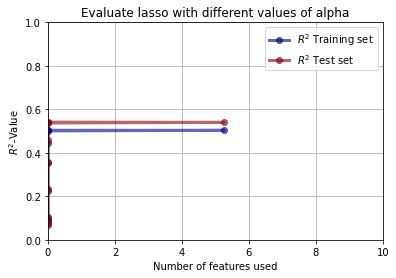

In [116]:
import mglearn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

# Question 1~3: Function scikit_diabetes loads the scikit-learn diabetes dataset and 
# prints the training and test R^2 value with the number of features used along with their names
def scikit_diabetes():
    diabetes_dataset = load_diabetes()    
    X_train_diabetes, X_test_diabetes, y_train_diabetes, y_test_diabetes = train_test_split(diabetes_dataset['data'],diabetes_dataset['target'], random_state=7196)
    lasso = Lasso().fit(X_train_diabetes,y_train_diabetes)
    print_R2(lasso,X_train_diabetes,y_train_diabetes,X_test_diabetes,y_test_diabetes) 

# print_R2 function prints the training and test R^2 
# function print_R2 accepts arguments lasso_fit, X_train_set, y_train_set,X_test_set and y_test_set
def print_R2(lasso_fit,X_train_set,y_train_set,X_test_set,y_test_set):
    print("Training set score: {:.2f}".format(lasso_fit.score(X_train_set,y_train_set)))
    print("Test set score: {:.2f}".format(lasso_fit.score(X_test_set, y_test_set)))
    print("Number of features used: {}".format(np.sum(lasso_fit.coef_ != 0)))
    print("Features that Lasso uses: ",end="")
    for i in range(len(lasso_fit.coef_)):
        if(lasso_fit.coef_[i] != 0):
            print(diabetes_dataset.feature_names[i],end=" ")
    print("\n")

def plot_lasso(X_train,y_train,X_test,y_test):
    alphas = (0.001, 0.01, 0.1, 1, 10, 20, 30, 38, 39, 40)
    l_num = 10
    train_R2 = np.zeros(l_num)
    test_R2 = np.zeros(l_num)
    for ind, i in enumerate(alphas):    
        lasso = Lasso(alpha = i)
        lasso.fit(X_train, y_train)
        train_R2[ind] = lasso.score(X_train, y_train)
        test_R2[ind] = lasso.score(X_test, y_test)
    print(len(train_R2))
    print(len(lasso.coef_))
    plt.plot(lasso.coef_, train_R2, 'bo-', label=r'$R^2$ Training set', color="darkblue", alpha=0.6, linewidth=3)
    plt.plot(lasso.coef_, test_R2, 'bo-', label=r'$R^2$ Test set', color="darkred", alpha=0.6, linewidth=3)
    plt.xlabel('Number of features used'); 
    plt.ylabel(r'$R^2$-Value')
    plt.xlim(0, 10)
    plt.ylim(0,1)
    plt.title(r'Evaluate lasso with different values of alpha')
    plt.legend(loc='best')
    plt.grid()

def cross_validation_gridsearch(X_train_scaled, y_train, X_test_scaled, y_test):
    param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}

    grid_search = GridSearchCV(SVC(), param_grid, cv=5)
    grid_search.fit(X_train_scaled, y_train)
    grid_search.score(X_test_scaled, y_test)
    
    lasso_cv = Lasso(alpha=grid_search.best_params_["C"])
    lasso_cv = Lasso().fit(X_train_scaled,y_train)
    print("Diabetes Dataset Scores After Applying Cross-Validation: ")
    print_R2(lasso_cv,X_train_scaled,y_train,X_test_scaled,y_test)
    return grid_search.best_params_
    
def compute_inductive_conformal_prediction(X_data,y_target,best_alpha_value):
    X_train__, X_test__, y_train__, y_test__ = train_test_split(X_data, y_target, random_state=7196)

    X_train_proper, X_calibration, y_train_proper, y_calibration = train_test_split(X_train__, y_train__, test_size=99, random_state=7196) 

    scaler_conformal = StandardScaler()
    scaler_conformal.fit(X_train_proper)

    X_train_proper_scaled = scaler_conformal.transform(X_train_proper)
    X_calibration_scaled = scaler_conformal.transform(X_calibration)
    X_test_proper_scaled = scaler_conformal.transform(X_test)
    
    lasso_inductive = Lasso(alpha=best_alpha_value)
    lasso_inductive = Lasso().fit(X_train_proper_scaled,y_train_proper)
    y_hat = lasso_inductive.predict(X_calibration_scaled)
    y_hat_test = lasso_inductive.predict(X_test_proper_scaled)
    
    alpha_value_list = []
    epsilon_list = [0.05,0.20]
    
    for i in range(len(X_calibration_scaled)):
        alpha_value_list.append(abs(y_calibration[i]-y_hat[i]))
       
    for i in range(len(epsilon_list)):
        epsilon = epsilon_list[i]
        k_value = (1-epsilon)*(len(X_calibration)+1)
        k_value = int(k_value)
        c_value = alpha_value_list[k_value] 
        correct_predicition = 0
        success_rate = 0
        error_rate = 0
        predicition_set_list = []
        for i in range(len(y_hat_test)):
            sub_list = []
            lower_index = y_hat_test[i]-c_value
            upper_index = y_hat_test[i]+c_value
            sub_list.append(lower_index)
            sub_list.append(upper_index)
            predicition_set_list.append(sub_list)
        
        for i in range(len(predicition_set_list)):
            if(y_test__[i] >= predicition_set_list[i][0] and y_test__[i] <= predicition_set_list[i][1]):
                correct_predicition = correct_predicition+1
        success_rate = correct_predicition/len(predicition_set_list)
        error_rate = 1-success_rate
        print("The test error rate of the dataset when epsilon : {}".format(error_rate))
    
    
# Question 1~3: Loading the scikit-learn diabetes dataset
print("Scikit-Learn-Diabetes Dataset Scores: ")
scikit_diabetes()

# Question 4~6: Loading the original diabetes dataset and applying train_test_split on it.
# And, printing the training and test R^2 value with the number of features used along with their names
X_data = np.loadtxt("diabetes.data", delimiter="\t",usecols=np.arange(10),skiprows=1)
y_target = np.loadtxt("diabetes.data", delimiter="\t",usecols=10, dtype='int',skiprows=1)
X_train, X_test, y_train, y_test = train_test_split(X_data, y_target, random_state=7196)
lasso_ = Lasso().fit(X_train,y_train)
print("Original Diabetes Dataset Scores: ")
print_R2(lasso_,X_train,y_train,X_test,y_test)
print("Question-6: Difference in score between Scikit-learn diabetes dataset and original diabetes dataset is because the former is normalized where as the latter has not be applied by any Normalization transformations. \n")

# Question 7: Pre-processing the data using StandardScaler normalization and applying the transformation to both train and test set
scaler_standard = StandardScaler()
scaler_standard.fit(X_train)
X_train_scaled = scaler_standard.transform(X_train)
X_test_scaled = scaler_standard.transform(X_test)

# Question 8: Calculating the lasso_score for the training and test set after applying StandardScaler Normalization
lasso_scaled = Lasso().fit(X_train_scaled,y_train)
print("Diabetes Dataset Scores After Applying StandardScalar Normalization: ")
print_R2(lasso_scaled,X_train_scaled,y_train,X_test_scaled,y_test)
print("Question-8: After applying StandardScalar Normalization to the original Diabetes Dataset, the training and test score values are closer to the Original Diabetes dataset scores before applying normalization. In theory,after the scores normalization should align with the scores obtained from scikit-learn diabetes dataset, but there maybe a lot of other reasons the model might be behaving poorly-difference in training data,random_states,outliers,overfitting and underfitting. It may also be due to the high varaince on a particular feature. One of the other solution might be- varying the random_state, this might make the model predict better.\n")

# Question 9: Varying the parameter-alpha and plotting it in a graph
plot_lasso(X_train_scaled,y_train,X_test_scaled,y_test)
print("Question-9: At R^2 value = 0.5 the points seem relevant. As we keep increasing the alpha value, most of the irrelevant coeffecients are brought down to 0. \n")

# Question 10: Implementing cross-validation using Grid search
best_alpha_value = cross_validation_gridsearch(X_train_scaled,y_train,X_test_scaled,y_test)

# Question 11: Implementing inductive conformal predictor
compute_inductive_conformal_prediction(X_data,y_target,best_alpha_value)



